# Multi-Disciplinary Design Optimization

# Parameters and Utility Functions

In [1]:
# Nelder-Mead simplex search
%matplotlib inline
import numpy as np
from math import sqrt, pi, exp, log, cos
from scipy.optimize import minimize, differential_evolution
import pylab
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
%run openrocket_interface.ipynb
%run trajectory.ipynb

# i'm sorry for global vars...
global allvectors, dbz, allobjval
dbz = 0 # arithmetic error tracker (from crossing boundary constraints)

# SIMULATION AND OPTIMIZATION PARAMETERS
delta = 10**(-6)       # a guess at a good margin for design "convergence"
time_step = 0.25       # change time-step for trajectory simulation
iterations = 25        # number of escalating iteration sequences
launch_site_alt = 1401 # m, altitude of launch site above sea level

##CHANGE INITIAL DESIGN GUESS HERE
# be sure that you start with a feasible design, otherwise the problem will be ill-conditioned
L = 1.3    # Total tank lengths (m)
mdot = 2.1 # Propellant mass flow rate (kg/s)
dia = 12.  # Rocket diameter (in)
p_e = 47.  # Exit Pressure (kPa)

#CHANGE CONSTRAINTS HERE
cons_mass = 200.                         # GLOW constraint, kg, somewhat arbitrary
cons_ls = 22.                            # min launch speed from 60' tower constraint, m/s
cons_TWR = 2.                            # TWR constraint
cons_S_crit = 0.35                       # Critical pressure ratio constraint
cons_accel = 15.                         # Max acceleration constraint, g's
cons_LD = 18.                            # L/D ratio constraint, slightly arbitrary
cons_alt = 107000. + launch_site_alt     # Min altitude constraint, km (adjusted to overshoot)
cons_thrust = 6.                         # max ground-level thrust, kN
cons_ceiling = 150000. + launch_site_alt # base-11 maximum apogee requirement, km

shirt_l = shirt_l  # non-engine subsystems lengths
g_n = g_n             # standard gravity
X0 = np.array([L, mdot, p_e]) # numpy arrays are nicer
allvectors = []               # array for all design vecs, global variable
allobjfun = []                # array for tracking objective function evaluations

# calculates length-diameter ratio
def ld_ratio(pants_l, dia):
    total_l = shirt_l + pants_l # add shirt and pants lengths for total rocket length
    D = dia * 0.0254            # converts in to m for total airframe diameter
    return total_l / D
    
# calculates top g-force
def max_g_force(a):
    return max(abs(a)) / g_n

# Math Utility Functions

In [2]:
# all of our comparisons are ratios instead of subtractions because
# it's normalized, instead of dependant on magnitudes of constraints

# minimize this, **2 makes it well behaved w.r.t. when var=cons
def objective(var, cons):
    return (var/cons)**2 / 2

# **2 because i like it more than abs(), but that also works
def exact(var, cons):
    return (var/cons - 1)**2 / 2

# this is your basic exterior penalty, either punishes for unfeasibility or is inactive
def exterior(var, cons, good_if_less_than=False):
    if good_if_less_than:
        return max(0, var/cons - 1)**2 / 2
    else:
        return max(0, -(var/cons - 1))**2 / 2

# this barrier function restricts our objective function to the strictly feasible region
# make rockets great again, build that wall, etc, watch out for undefined operations
def barrier(var, cons, int_point=False, good_if_less_than=True):
    global dbz
    def interior(g): # in case we don't like logarithms
        return 1/g
    try: # just in case we accidentally leave feasible region
        if not int_point:
            if good_if_less_than:
                return -log(-(var/cons - 1))
            else:
                return -log((var/cons - 1))
        elif int_point:
            if good_if_less_than:
                return -interior(var/cons - 1)
            else:
                return -interior(-(var/cons - 1))
    except:
        dbz += 1 # keep track of arithmetic errors, side effect
        return float('inf')

# Optimization Problem

In [3]:
# this manages all our constraints
# penalty parameters: mu -> 0 and rho -> infinity 
def penalty(ls, F, LD, TWR, S_crit, alt, max_g, mu, rho):
    b = [barrier(alt, cons_alt, int_point=False, good_if_less_than=False),
         barrier(alt, cons_ceiling, int_point=False, good_if_less_than=True)]
    eq = [exact(F, cons_thrust)]
    ext = [exterior(ls, cons_ls, good_if_less_than=False),
           exterior(LD, cons_LD, good_if_less_than=True),
           exterior(TWR, cons_TWR, good_if_less_than=False),
           exterior(S_crit, cons_S_crit, good_if_less_than=False),
           exterior(max_g, cons_accel, good_if_less_than=True)]
    return mu*sum(b) + rho*(sum(eq) + sum(ext))

# Pseudo-objective function
# x is array of design parameters, n is sequence index of penalty and barrier functions
# print blocks are sanity checks so i'm not staring at a blank screen and can see what various tweaks actually do
def f(x, n=8):
    global allvectors, allobjfun
    L    = x[0]  # Tank length (m)
    mdot = x[1]  # Propellant mass flow rate (kg/s)
    p_e  = x[2]  # Pressure (kPa)
    
    # get trajectory data from x
    sim = trajectory(L, mdot, dia, p_e, x_init=launch_site_alt, dt=time_step)
    r, l_o, l_f = split_tanks(sim.m_prop[0], dia)
    
    obj_func = objective(sim.m[0], cons_mass) # minimize GLOW
    # then, calculate penalization from trajectory based on initial thrust
    pen_func = penalty(sim.launch_speed,
                  sim.F[0]/1000,
                  ld_ratio(system_length(l_o, l_f), dia),
                  sim.TWR,
                  sim.S_crit,
                  sim.alt[-1],
                  max_g_force(sim.a),
                  (0.10) / (2**n),   # initial mu and
                  (1.25) * (2**n)) #                rho are selected for nice behavior
    # add objective and penalty functions
    merit_func = obj_func + pen_func
    
    allvectors.append(x) # maintains a list of every design, side effect
    allobjfun.append(log(merit_func)) # log plot is cleaner to look at
    return merit_func

# we want to iterate our optimizer for theoretical "convergence" reasons (given some assumptions)
# n = number of sequential iterations
def iterate(f, x_0, n):
    x = x_0 # initial design vector
    global dbz
    designs = []
    for i in range(n):
        print("Iteration " + str(i+1) + ":")
        # this minimizer uses simplex method
        res = minimize(f, x, args=(i), method='nelder-mead', options={'disp': True, 'adaptive':True})
        x = res.x # feed optimal design vec into next iteration
        designs.append(res.x)   # we want to compare sequential objectives 
                                # so we can stop when convergence criteria met
        alt = trajectory(x[0], x[1], dia, x[2], x_init=launch_site_alt, dt=time_step).alt
        
        print("         Arithmetic errors (from violations of acceptable altitude window): "+str(dbz))
        print("Propellant tube length (m): "+str(x[0]))
        print("Mass flow rate (kg/s): "+str(x[1]))
        print("Exit pressure (kPa): "+str(x[2]))
        print("Peak Altitude (km): "+str(alt[-1]))
        print('')
        dbz=0 # I only care about divisions by zero in each individual iteration, side effect
        if (i > 0) and (sqrt(sum([(designs[-1][k] - designs[-2][k])**2 for k in range(len(x))])) < delta):
            print("Early termination! The Euclidean distance between the last two designs was < " + str(delta))
            break
    return x

# Optimization Information and Graphing

In [4]:
# this creates a list of strings for relevant data of trajectory
def print_results(res):
    text_base = [] # list of lines of strings
    
    # Rename the optimized output for convenience
    L    = res[0]
    mdot = res[1]
    p_e  = res[2]
    
    sim = trajectory(L, mdot, dia, p_e, x_init=launch_site_alt, dt=time_step) 
    r, l_o, l_f = split_tanks(sim.m_prop[0], dia)
    eng_sys_len = system_length(l_o, l_f)
    
    np.set_printoptions(precision=3) # this line may be deprecated, i copy-pasted most of this section
    
    text_base.append('\nOPTIMIZED DESIGN VECTOR')
    text_base.append('\n-----------------------------')
    text_base.append('\nx_initial_guess                            = ' + ', '.join(
                                                                            [str(X0[0]), str(X0[1]), str(X0[2])]))
    text_base.append('\ninitial guess GLOW                                    = {:.1f} kg'.format( \
          trajectory(X0[0], X0[1], dia, X0[2], x_init=launch_site_alt, dt=time_step).m[0]))
    text_base.append('\nx_optimized                                = ' + ', '.join([str(L), str(mdot), str(p_e)]))
    text_base.append('\ndesign airframe diameter                   = {:.3f} in.'.format(dia))
    text_base.append('\ndesign tankage length (before adjustment)  = {:.3f} m'.format(L))
    text_base.append('\ndesign mass flow rate                      = {:.3f} kg/s'.format(mdot))
    text_base.append('\ndesign nozzle exit pressure                = {:.3f} kPa'.format(p_e))
    text_base.append('\ndesign tankage length (after adjustment)   = {:.3f} m'.format(l_o + l_f))
    text_base.append('\ndesign GLOW                                = {:.3f} kg'.format(sim.m[0]))
    
    text_base.append('\n')
    text_base.append('\nCONSTRAINTS')
    text_base.append('\n-----------------------------')
    text_base.append('\nL/D ratio (c.f. < {})                      = {:.3f}'.format(
                                                                            cons_LD, ld_ratio(eng_sys_len, dia)))
    text_base.append('\nSommerfield criterion (c.f. pe/pa >= {})   = {:.3f}'.format(cons_S_crit, sim.S_crit))
    text_base.append("\nmax acceleration (c.f. < {})               = {:.3f} gs".format(
                                                                                cons_accel, max_g_force(sim.a)))
    text_base.append('\nTWR at lift off (c.f. > {})                 = {:.3f}'.format(cons_TWR, sim.TWR))
    text_base.append('\nspeed when leaving launch rail (c.f. > {}) = {:.3f} m/s'.format(cons_ls,sim.launch_speed))
    text_base.append('\naltitude at apogee (c.f. > {})          = {:.3f} km'.format(
                                                                                cons_alt/1000, sim.alt[-1]/1000))
    text_base.append('\ndesign thrust (ground level) (c.f. = {})    = {:.3f} kN'.format(
                                                                                     cons_thrust, sim.F[0]/1000))

    text_base.append('\n')
    text_base.append('\nADDITIONAL INFORMATION')
    text_base.append('\n-----------------------------')
    text_base.append('\ndesign thrust (vacuum)                     = {:.2f} kN'.format(sim.F[sim.F_index]/1000))
    text_base.append('\ndesign total dry mass                      = {:.3f} kg'.format(sim.m_dry))
    text_base.append('\ndesign total propellant mass               = {:.3f} kg'.format(sim.m_prop[0]))
    text_base.append('\naltitude at engine ignition                = {:.1f} m'.format(launch_site_alt))
    text_base.append('\nmission time at apogee                     = {:.3f} s'.format(sim.t[-1]))
    text_base.append('\nmission time at burnout                    = {:.3f} s'.format(sim.t[sim.F_index]))
    text_base.append('\ndesign chamber pressure                    = {:.3f} psi'.format(350))
    text_base.append('\ndesign expansion ratio                     = {:.3f}'.format(sim.ex))
    text_base.append('\ndesign throat area                         = {:.3f} in.^2'.format(sim.A_t/0.0254**2))
    text_base.append('\ndesign isp                                 = {:.3f} s'.format(sim.Ve/g_n))
    text_base.append('\ndesign total impulse                       = {:.3f} kN*s'.format(
                                                  sim.t[sim.F_index]*(sim.F[sim.F_index]/1000 + sim.F[0]/1000)/2))
    text_base.append('\ndesign dV                                  = {:.3f} km/s'.format(sim.dV1))
    text_base.append('\nestimated minimum required dV              = {:.3f} km/s'.format(
                                                                                    sqrt(2*g_n*sim.alt[-1])/1000))
    return text_base

# this creates a nice set of plots of our trajectory data and saves it to rocket_farm
def rocket_plot(t, alt, v, a, F, q, Ma, m, p_a, D):
    pylab.rcParams['figure.figsize'] = (10.0, 10.0)
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, sharex=True)
    
    for n in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9):
        n.spines['top'].set_visible(False)
        n.spines['right'].set_visible(False)
        n.yaxis.set_ticks_position('left')
        n.xaxis.set_ticks_position('bottom')
        n.yaxis.labelpad = 20
        
    ax1.plot(t, alt/1000, 'k')
    ax1.set_ylabel("Altitude (km)")
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_title('LV4 Trajectory')
    
    ax2.plot(t, v, 'k')
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_ylabel("Velocity (m/s)")
    
    ax3.plot(t, a/g_n, 'k')
    ax3.yaxis.major.locator.set_params(nbins=10)
    ax3.set_ylabel("Acceleration/g_n")
    
    ax4.plot(t, F/1000, 'k')
    ax4.yaxis.major.locator.set_params(nbins=6)
    ax4.set_ylabel("Thrust (kN)")
    
    ax5.plot(t, q/1000, 'k')
    ax5.yaxis.major.locator.set_params(nbins=6)
    ax5.set_ylabel("Dynamic Pressure (kPa)")
    
    ax6.plot(t, Ma, 'k')
    ax6.yaxis.major.locator.set_params(nbins=6) 
    ax6.set_ylabel("Mach number")
    ax6.set_xlabel("t (s)")
    
    ax7.plot(t, np.array(m)*0.666*np.array(a), 'k')
    ax7.yaxis.major.locator.set_params(nbins=6) 
    ax7.set_ylabel("LOX Tank Axial Load")
    ax7.set_xlabel("t (s)")
    
    ax8.plot(t, D, 'k')
    ax8.yaxis.major.locator.set_params(nbins=6)
    ax8.set_ylabel("Drag (N)")
    
    ax9.plot(t, p_a/1000, 'k')
    ax9.yaxis.major.locator.set_params(nbins=6)
    ax9.set_ylabel("Air Pressure (Pa)")
    
    # we save the nice figures we make and then display them
    plt.savefig(rkt_prefix +'psas_rocket_'+str(get_index()-1)+'_traj.svg')
    plt.show()

# this creates some plots of the phase spaces of all our designs, doesn't save them
def phase_plot(L, mdot, p_e):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    
    ax1.plot(L, p_e)
    ax1.set_title('Design Vectors')
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_xlabel("Length (m)")
    ax1.set_ylabel("Exit pressure (kPa)")
    
    ax2.plot(mdot, p_e)
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_xlabel("Mass flow rate (kg/s)")
    ax2.set_ylabel("Exit pressure (kPa)")
    
    ax3.plot(L, mdot)
    ax3.yaxis.major.locator.set_params(nbins=6)
    ax3.set_ylabel("Mass flow rate (kg/s)")
    ax3.set_xlabel("Length (in)")
    
    # we display the first diagram of projected 2d phase portraits
    plt.show()
    
    fig2 = plt.figure()
    ax = fig2.add_subplot(111, projection='3d')
    ax.set_title('Design Space Trajectory')
    ax.plot(L, mdot, p_e)
    ax.set_xlabel("Length (m)")
    ax.set_ylabel("Mass flow rate (kg/s)")
    ax.set_zlabel("Exit pressure (kPa)")
    
    # we display the interactive 3d phase portrait
    plt.show()
    # note, we're choosing to not automatically save these, but they can be saved from the interface
    fig3 = plt.figure()
    ax = fig3.add_subplot(111)
    ax.set_title('Design Values as % of optimum design value')
    ax.plot(L/(L[-1]), "r", label="L")
    ax.plot(mdot/(mdot[-1]), "g", label="Mdot")
    ax.plot(p_e/(p_e[-1]), "b", label="p_e")
    ax.legend()
    plt.show()

def design_grapher(): # no arguments because I'm using dirty dirty global variables
    # get us some nice plots of the phase space of design vectors
    designplot = [[],[],[]]
    for i in range(0, len(allvectors)):
        for j in range(0, len(designplot)):
            designplot[j].append(allvectors[i][j])
    phase_plot(designplot[0], designplot[1], designplot[2])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Objective + Constraint convergence')
    ax.plot(allobjfun, "r", label="Objective Function Evaluations (Logarithmic Scale)")
    ax.legend()
    plt.show()

# Top-Level of Optimization Routine

Iteration 1:
Optimization terminated successfully.
         Current function value: 0.741664
         Iterations: 71
         Function evaluations: 180
         Arithmetic errors (from violations of acceptable altitude window): 0
Propellant tube length (m): 1.3843877679804635
Mass flow rate (kg/s): 2.3595232599248863
Exit pressure (kPa): 42.49121287172372
Peak Altitude (km): 127604.42664611402

Iteration 2:
         Arithmetic errors (from violations of acceptable altitude window): 0
Propellant tube length (m): 1.3647625294170456
Mass flow rate (kg/s): 2.4111747731342428
Exit pressure (kPa): 43.24118008208434
Peak Altitude (km): 123420.09939539924

Iteration 3:
Optimization terminated successfully.
         Current function value: 0.465492
         Iterations: 150
         Function evaluations: 304
         Arithmetic errors (from violations of acceptable altitude window): 1
Propellant tube length (m): 1.3444909435063241
Mass flow rate (kg/s): 2.43474424447424
Exit pressure (kPa): 44.1

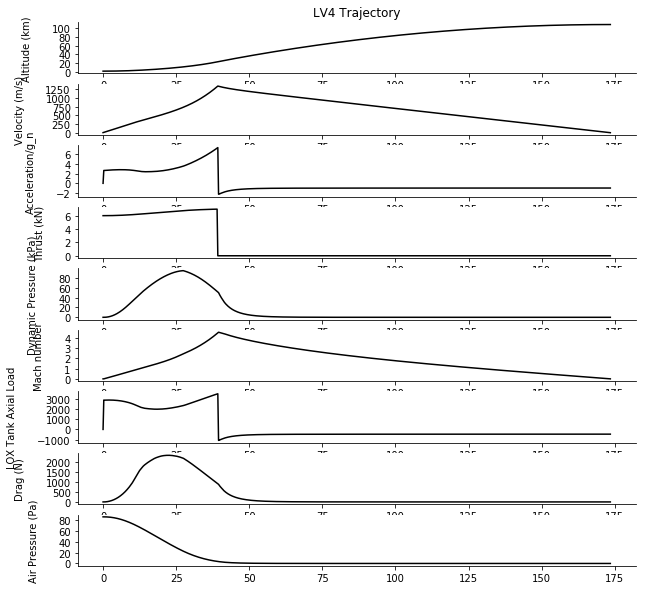

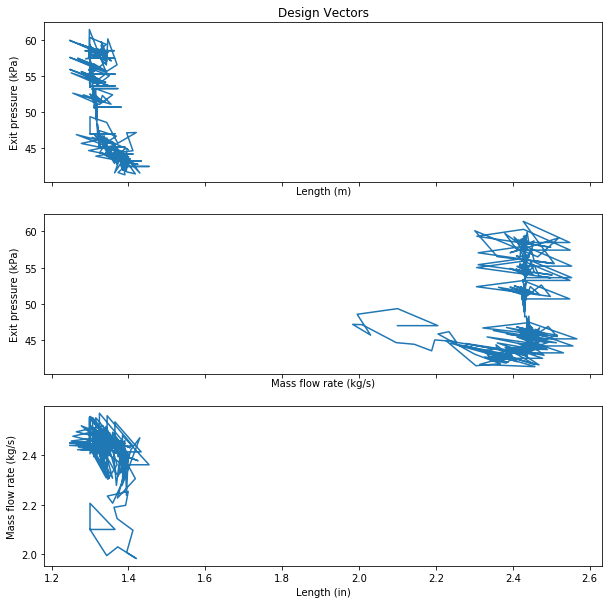

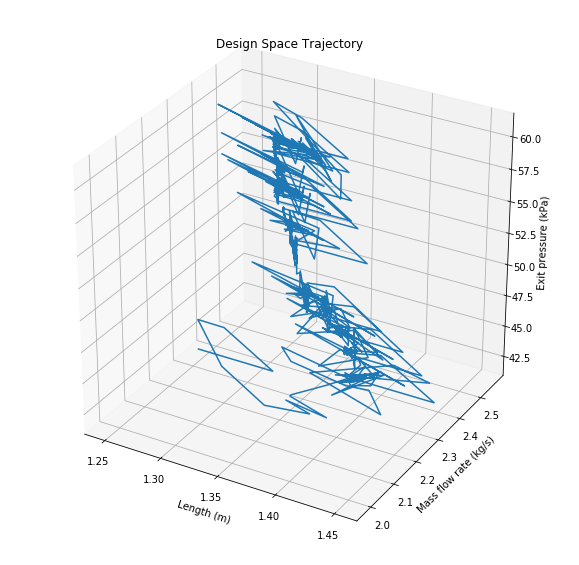

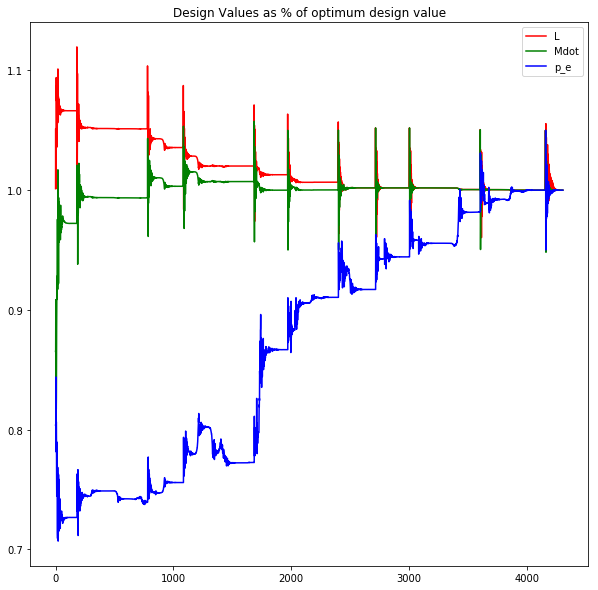

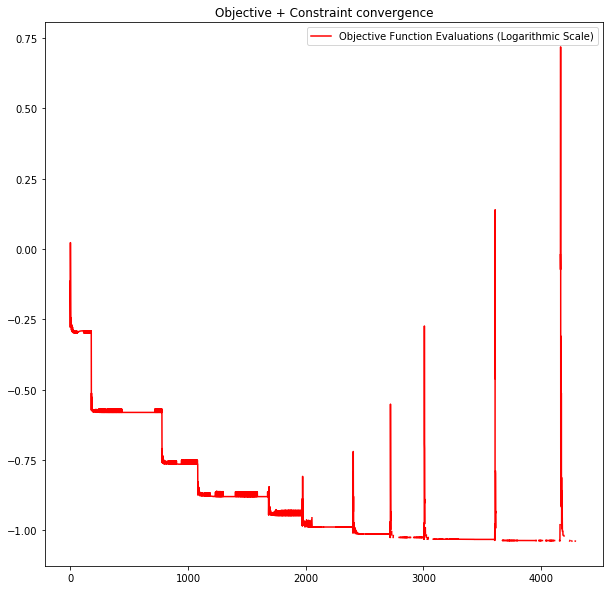

In [5]:
# Results, this is the big boi function
if __name__ == '__main__': # Testing  
    # feed initial design into iterative optimizer, get best design
    res = iterate(f, X0, iterations)
    print("Optimization done!")
    
    # Rename the optimized output for convenience
    L    = res[0]
    mdot = res[1]
    p_e  = res[2]
    
    # get trajectory info from optimal design
    sim = trajectory(L, mdot, dia, p_e, x_init=launch_site_alt, dt=time_step)  
    
    # get/print info about our trajectory and rocket
    res_text = print_results(res)
    for line in res_text:
        print(line)
    print('Engine system details in trajectory log!')
    print('\nMaking an OpenRocket rocket and corresponding engine!')
    
    # create an openrocket file with matching engine for our design (and print/save trajectory data)
    make_engine(mdot, sim.m_prop[0], dia, sim.F[0:sim.F_index + 1], sim.t[sim.F_index], sim.Ve/g_n, res_text)
    
    # draw pretty pictures of optimized trajectory
    rocket_plot(sim.t, sim.alt, sim.v, sim.a, sim.F, sim.q, sim.Ma, sim.m, sim.p_a, sim.D)
    
    # draw more pretty pictures, but of the optimizer guts
    design_grapher()